In [ ]:
!pip install mlflow
!pip install plot_keras_history



import mlflow
import mlflow.keras
from mlflow.tracking import MlflowClient
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from plot_keras_history import show_history
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
import h5py

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9456 sha256=7f201e2608b79526df1f0e8930cb6ae7fb6c84bfbac8f74b44dabe44ec4c64e3
  Stored in directory: /root/.cache/pip/wheels/2f/31/6c/bbc9703b7baa8bd3802a8aedd9e2f9e66941b0cf0d456ab4cc
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.51-py3-none-any.whl size=321866 sha256=b485667699c211519af5863e9c788f5ec98601609c3ba6f1c3618aa3f2d2cd07
  Stored in directory: /root/.cache/pip/wheels/30/9f/f5/37d037c39ac8b305590d5956f7021c6ca94b63c68be24f6841
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5630 sha256=d451f45b4da75aa37f891c7c48bf9f2ad600cbae02b939f687d720a84b4136b0
  Stored in directo

In [ ]:
# Set up MLflow
mlflow.set_tracking_uri("http://localhost:5000")  # Replace with your MLflow tracking URI
mlflow.set_experiment("MNIST Digit Classification")  # Set the experiment name

In [2]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
num_classes = 10
x_train = X_train.reshape(60000, 784)
x_test = X_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape, 'train input samples')
print(x_test.shape, 'test input samples')

11490434/11490434 [==============================] - 0s 0us/step
(60000, 784) train input samples
(10000, 784) test input samples


In [3]:
y_train = keras.utils.to_categorical(Y_train, num_classes)
y_test = keras.utils.to_categorical(Y_test, num_classes)
print(y_train.shape, 'train output samples')
print(y_test.shape, 'test output samples')

(60000, 10) train output samples
(10000, 10) test output samples


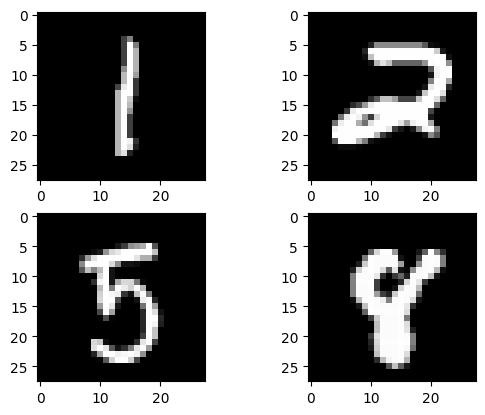

In [4]:
plt.subplot(221)
plt.imshow(X_train[310], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[515], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[1210], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[2150], cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
# In each model block, add the following lines before model training:
mlflow.autolog()

with mlflow.start_run(run_name="basic") as run:
    # let's try a basic neural network for digit classification
    model = keras.Sequential()
    model.add(layers.Dense(20, activation='sigmoid', input_shape=(784,)))
    model.add(layers.Dense(20, activation='sigmoid'))
    model.add(layers.Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
    show_history(history)
    loss, acc = model.evaluate(x_test, y_test, verbose=2)
    print("Test accuracy: {:5.2f}%".format(100*acc))
    loss, acc = model.evaluate(x_train, y_train, verbose=2)
    print("Train accuracy: {:5.2f}%".format(100*acc))
    # check if the prediction is working fine for a random test point
    test_pt = 782
    plt.imshow(X_test[test_pt], cmap=plt.get_cmap('gray'))
    probs = model.predict(x_test[test_pt:test_pt+1], verbose=True)
    print("Predicted Digit:", np.argmax(probs))

In [27]:
# In each model block, add the following lines before model training:
mlflow.autolog()

with mlflow.start_run(run_name="bigger") as run:
    # Let's try with a slightly bigger model with more parameters.
    model2 = keras.Sequential()
    model2.add(layers.Dense(256, activation='sigmoid', input_shape=(784,)))
    model2.add(layers.Dense(128, activation='sigmoid'))
    model2.add(layers.Dense(10, activation='softmax'))
    model2.summary()
    model2.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    history = model2.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
    show_history(history)
    loss, acc = model2.evaluate(x_test, y_test, verbose=2)
    print("Test accuracy: {:5.2f}%".format(100*acc))
    loss, acc = model2.evaluate(x_train, y_train, verbose=2)
    print("Train accuracy: {:5.2f}%".format(100*acc))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               200960    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235146 (918.54 KB)
Trainable params: 235146 (918.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
# In each model block, add the following lines before model training:
mlflow.autolog()

with mlflow.start_run(run_name="regularized") as run:
    # let's try adding kernel regularization to the mix.
    model_r = keras.Sequential()
    model_r.add(layers.Dense(256, activation='sigmoid', input_shape=(784,), kernel_regularizer=regularizers.L2(0.01)))
    model_r.add(layers.Dense(128, activation='sigmoid', kernel_regularizer=regularizers.L2(0.01)))
    model_r.add(layers.Dense(10, activation='softmax'))
    model_r.summary()
    model_r.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    history_r = model_r.fit(x_train, y_train, epochs=50, steps_per_epoch=50, validation_data=(x_test, y_test))
    loss, acc = model_r.evaluate(x_test, y_test, verbose=2)
    print("Test accuracy: {:5.2f}%".format(100*acc))
    loss, acc = model_r.evaluate(x_train, y_train, verbose=2)
    print("Train accuracy: {:5.2f}%".format(100*acc))
    show_history(history_r)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 256)               200960    
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dense_17 (Dense)            (None, 10)                1290      
                                                                 
Total params: 235146 (918.54 KB)
Trainable params: 235146 (918.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
# In each model block, add the following lines before model training:
mlflow.autolog()

with mlflow.start_run(run_name="dropout") as run:
    model_rd = keras.Sequential()
    model_rd.add(layers.Dense(256, activation='sigmoid', input_shape=(784,)))
    model_rd.add(Dropout(0.7))
    model_rd.add(layers.Dense(128, activation='sigmoid'))
    model_rd.add(Dropout(0.6))
    model_rd.add(layers.Dense(10, activation='softmax'))
    model_rd.summary()
    model_rd.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    history_rd = model_rd.fit(x_train, y_train, epochs=10)
    show_history(history_rd)
    loss, acc = model_rd.evaluate(x_test, y_test, verbose=2)
    print("Test accuracy: {:5.2f}%".format(100*acc))
    loss, acc = model_rd.evaluate(x_train, y_train, verbose=2)
    print("Train accuracy: {:5.2f}%".format(100*acc))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 10)                1290      
                                                                 
Total params: 235146 (918.54 KB)
Trainable params: 235146 (918.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
# In each model block, add the following lines before model training:
mlflow.autolog()

with mlflow.start_run(run_name="early") as run:
    model_re = keras.Sequential()
    model_re.add(layers.Dense(256, activation='sigmoid', input_shape=(784,)))
    model_re.add(layers.Dense(128, activation='sigmoid'))
    model_re.add(layers.Dense(10, activation='softmax'))
    model_re.summary()
    model_re.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    # model will get saved at the end of every epoch automatically.
    checkpoint = ModelCheckpoint(r"mnist-epoch-{epoch:02d}.hdf5")
    history_es = model_re.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), callbacks=[checkpoint])
    show_history(history_es)
    es = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=2)
    model_re.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), callbacks=[es])


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 256)               200960    
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dense_23 (Dense)            (None, 10)                1290      
                                                                 
Total params: 235146 (918.54 KB)
Trainable params: 235146 (918.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# In each model block, add the following lines before model training:
mlflow.autolog()

with mlflow.start_run(run_name="learning") as run:
    # Using LEarning rates now.
    model3 = keras.Sequential()
    model3.add(layers.Dense(20, activation='sigmoid', input_shape=(784,)))
    model3.add(layers.Dense(10, activation='sigmoid'))
    model3.add(layers.Dense(10, activation='softmax'))
    model3.summary()
    opt_new = keras.optimizers.SGD(learning_rate=10)
    model3.compile(optimizer=opt_new, loss='categorical_crossentropy', metrics=['accuracy'])
    model3.fit(x_train, y_train, epochs=20)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 20)                15700     
                                                                 
 dense_25 (Dense)            (None, 10)                210       
                                                                 
 dense_26 (Dense)            (None, 10)                110       
                                                                 
Total params: 16,020
Trainable params: 16,020
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# In each model block, add the following lines before model training:
mlflow.autolog()

with mlflow.start_run(run_name="low") as run:
    # too low learning rate
    model3 = keras.Sequential()
    model3.add(layers.Dense(20, activation='sigmoid', input_shape=(784,)))
    model3.add(layers.Dense(10, activation='sigmoid'))
    model3.add(layers.Dense(10, activation='softmax'))
    model3.summary()
    opt_new = keras.optimizers.SGD(learning_rate=.00001)
    model3.compile(optimizer=opt_new, loss='categorical_crossentropy', metrics=['accuracy'])
    model3.fit(x_train, y_train, epochs=20)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 20)                15700     
                                                                 
 dense_28 (Dense)            (None, 10)                210       
                                                                 
 dense_29 (Dense)            (None, 10)                110       
                                                                 
Total params: 16,020
Trainable params: 16,020
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1875/1875 [==============================] - 4s 2ms/step - loss: 2.4651 - accuracy: 0.1124
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 2.4618 - accuracy: 0.1123
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 2.4586 - accuracy: 0.1123
Epoch 4

In [ ]:
# In each model block, add the following lines before model training:
mlflow.autolog()

with mlflow.start_run(run_name="optimal") as run:
    # optimal learning rate
    model3 = keras.Sequential()
    model3.add(layers.Dense(20, activation='sigmoid', input_shape=(784,)))
    model3.add(layers.Dense(10, activation='sigmoid'))
    model3.add(layers.Dense(10, activation='softmax'))
    model3.summary()
    opt_new = keras.optimizers.SGD(learning_rate=.01)
    model3.compile(optimizer=opt_new, loss='categorical_crossentropy', metrics=['accuracy'])
    model3.fit(x_train, y_train, epochs=20)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 20)                15700     
                                                                 
 dense_31 (Dense)            (None, 10)                210       
                                                                 
 dense_32 (Dense)            (None, 10)                110       
                                                                 
Total params: 16,020
Trainable params: 16,020
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1875/1875 [==============================] - 4s 2ms/step - loss: 2.2533 - accuracy: 0.2392
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 2.0421 - accuracy: 0.4538
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.7108 - accuracy: 0.5248
Epoch 4

In [ ]:
# In each model block, add the following lines before model training:
mlflow.autolog()

with mlflow.start_run(run_name="momentum") as run:
    # optimal learning rate with momentum
    model3 = keras.Sequential()
    model3.add(layers.Dense(20, activation='sigmoid', input_shape=(784,)))
    model3.add(layers.Dense(10, activation='sigmoid'))
    model3.add(layers.Dense(10, activation='softmax'))
    model3.summary()
    opt_new = keras.optimizers.SGD(learning_rate=.01, momentum=0.5)
    model3.compile(optimizer=opt_new, loss='categorical_crossentropy', metrics=['accuracy'])
    model3.fit(x_train, y_train, epochs=20)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 20)                15700     
                                                                 
 dense_37 (Dense)            (None, 10)                210       
                                                                 
 dense_38 (Dense)            (None, 10)                110       
                                                                 
Total params: 16,020
Trainable params: 16,020
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1875/1875 [==============================] - 5s 2ms/step - loss: 2.1416 - accuracy: 0.3215
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.5759 - accuracy: 0.5187
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.1739 - accuracy: 0.6662
Epoch 4

In [ ]:
# In each model block, add the following lines before model training:
mlflow.autolog()

with mlflow.start_run(run_name="mini") as run:
    # Mini-batch SGD
    # the default minibatch size is 32 unlike 1.
    model4 = keras.Sequential()
    model4.add(layers.Dense(20, activation='sigmoid', input_shape=(784,)))
    model4.add(layers.Dense(10, activation='sigmoid'))
    model4.add(layers.Dense(10, activation='softmax'))
    model4.summary()
    opt_new = keras.optimizers.SGD(learning_rate=.01, momentum=0.5)
    model4.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    model4.fit(x_train, y_train, batch_size=512, epochs=10)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 20)                15700     
                                                                 
 dense_61 (Dense)            (None, 10)                210       
                                                                 
 dense_62 (Dense)            (None, 10)                110       
                                                                 
Total params: 16,020
Trainable params: 16,020
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
118/118 [==============================] - 1s 4ms/step - loss: 2.1100 - accuracy: 0.3083
Epoch 2/10
118/118 [==============================] - 0s 4ms/step - loss: 1.7772 - accuracy: 0.5403
Epoch 3/10
118/118 [==============================] - 0s 4ms/step - loss: 1.5238 - accuracy: 0.5899
Epoch 4/10
11